# Image Classification Batch Inference with Huggingface Vision Transformer

In this example, we will introduce how to use the Ray Data for large-scale image classification batch inference with multiple GPU workers.

Source: https://docs.ray.io/en/latest/data/examples/huggingface_vit_batch_prediction.html

## Reading data from s3

In [1]:
import ray

s3_uri = "s3://anonymous@air-example-data-2/imagenette2/val/"

ds = ray.data.read_images(
    s3_uri, mode="RGB"
)
ds

2023-09-06 11:15:06,238	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 


Dataset(
   num_blocks=200,
   num_rows=3925,
   schema={image: numpy.ndarray(ndim=3, dtype=uint8)}
)

In [2]:
ds.schema()

Column  Type
------  ----
image   numpy.ndarray(ndim=3, dtype=uint8)

## Inference on a single batch

In [3]:
single_batch = ds.take_batch(10)

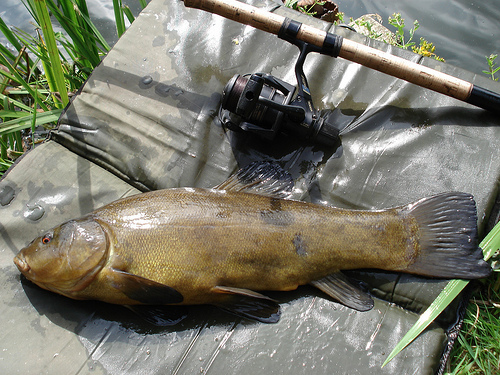

In [4]:
from PIL import Image

img = Image.fromarray(single_batch["image"][0])
img

In [5]:
from transformers import pipeline
from PIL import Image

# If doing CPU inference, set device="cpu" instead.
classifier = pipeline("image-classification", model="google/vit-base-patch16-224", device="cuda:0")
outputs = classifier([Image.fromarray(image_array) for image_array in single_batch["image"]], top_k=1, batch_size=10)
del classifier # Delete the classifier to free up GPU memory.
outputs

2023-09-06 11:15:46.488481: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-06 11:15:46.515619: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 11:15:46.977350: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[[{'score': 0.9997267127037048, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.9993537068367004, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.9997393488883972, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.99950110912323, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.9986729621887207, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.999290943145752, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.9997896552085876, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.9997585415840149, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.9985774755477905, 'label': 'tench, Tinca tinca'}],
 [{'score': 0.9996065497398376, 'label': 'tench, Tinca tinca'}]]

## Scaling up to the full Dataset with Ray Data

In [9]:
from typing import Dict
import numpy as np

from transformers import pipeline
from PIL import Image

# Pick the largest batch size that can fit on our GPUs
BATCH_SIZE = 240

class ImageClassifier:
    def __init__(self):
        # If doing CPU inference, set `device="cpu"` instead.
        self.classifier = pipeline("image-classification", model="google/vit-base-patch16-224", device="cuda:0")

    def __call__(self, batch: Dict[str, np.ndarray]):
        # Convert the numpy array of images into a list of PIL images which is the format the HF pipeline expects.
        outputs = self.classifier(
            [Image.fromarray(image_array) for image_array in batch["image"]], 
            top_k=1, 
            batch_size=BATCH_SIZE)
        
        # `outputs` is a list of length-one lists. For example:
        # [[{'score': '...', 'label': '...'}], ..., [{'score': '...', 'label': '...'}]]
        batch["score"] = [output[0]["score"] for output in outputs]
        batch["label"] = [output[0]["label"] for output in outputs]
        return batch

In [10]:
predictions = ds.map_batches(
    ImageClassifier,
    compute=ray.data.ActorPoolStrategy(size=1), # Use 1 GPUs. Change this number based on the number of GPUs in your cluster.
    num_gpus=1,  # Specify 1 GPU per model replica.
    batch_size=BATCH_SIZE # Use the largest batch size that can fit on our GPUs
)

In [11]:
prediction_batch = predictions.take_batch(5)

2023-09-06 11:17:55,366	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage] -> ActorPoolMapOperator[MapBatches(ImageClassifier)]
2023-09-06 11:17:55,366	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 11:17:55,366	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-09-06 11:17:55,478	INFO actor_pool_map_operator.py:117 -- MapBatches(ImageClassifier): Waiting for 1 pool actors to start...
(_MapWorker pid=49563) 2023-09-06 11:17:57.264800: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

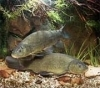

Label:  tench, Tinca tinca


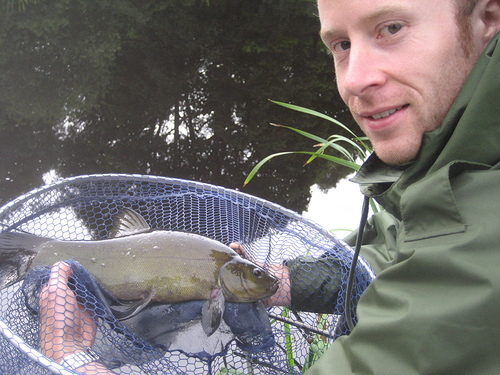

Label:  tench, Tinca tinca


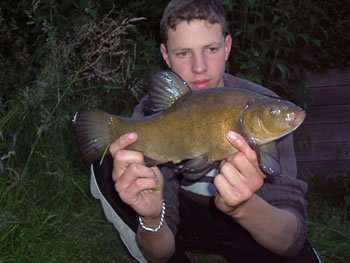

Label:  tench, Tinca tinca


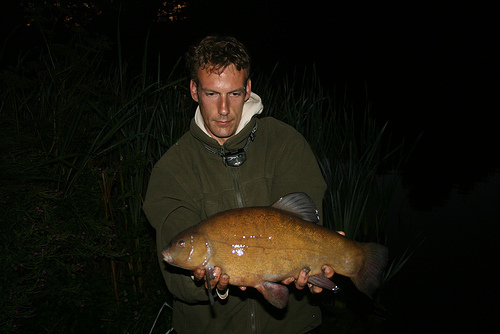

Label:  tench, Tinca tinca


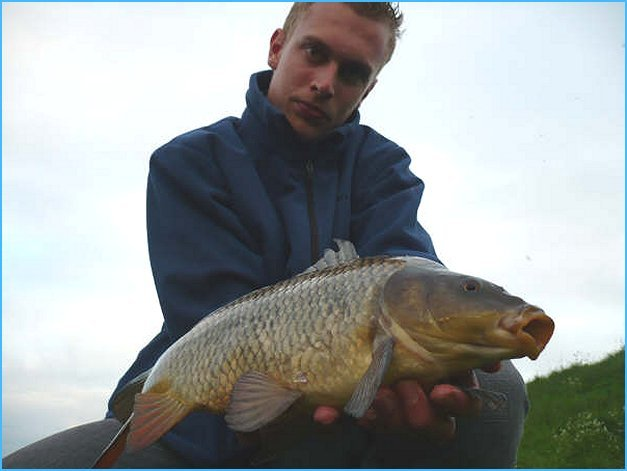

Label:  tench, Tinca tinca


In [12]:
from PIL import Image

for image, prediction in zip(prediction_batch["image"], prediction_batch["label"]):
    img = Image.fromarray(image)
    display(img)
    print("Label: ", prediction)

In [13]:
ds.write_parquet("local://tmp/inference_results")

2023-09-06 11:22:15,051	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->Write]
2023-09-06 11:22:15,052	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 11:22:15,052	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(ReadImage->Write pid=47942) Task failed with retryable exception: TaskID(1bb2b33f07900e46ffffffffffffffffffffffff01000000).
(ReadImage->Write pid=47942) Traceback (most recent call last):
(ReadImage->Write pid=47942)   File "python/ray/_raylet.pyx", line 1191, in ray._raylet.execute_dynamic_generator_and_store_task_outputs
(ReadImage->Write pid=47942)   File "python/ray/_raylet.pyx", line 3684, in ray._raylet.CoreWorker.store_task_outputs
(ReadImage->Write pid=47942)   File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/_internal/execution/operators/map_operator.py", line 415, in _map_task
(ReadImage->Write pid=47942)     for b_out in fn(iter(blocks), ctx):
(ReadImage->Write pid=47942)   File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/_internal/planner/plan_write_op.py", line 14, in do_write
(ReadImage->Write pid=47942)     yield from transform_fn(blocks, ctx)
(ReadImage->Write pid=47942)   File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packag

RayTaskError(OSError): [36mray::ReadImage->Write()[39m (pid=47933, ip=192.168.33.188)
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/_internal/execution/operators/map_operator.py", line 415, in _map_task
    for b_out in fn(iter(blocks), ctx):
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/_internal/planner/plan_write_op.py", line 14, in do_write
    yield from transform_fn(blocks, ctx)
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/_internal/planner/write.py", line 20, in fn
    {"write_result": [datasource.write(blocks, ctx, **write_args)]}
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/datasource/file_based_datasource.py", line 273, in write
    for block in blocks:
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/_internal/planner/plan_read_op.py", line 67, in do_read
    yield from read_task()
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/datasource/datasource.py", line 214, in __call__
    for block in result:
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/datasource/file_based_datasource.py", line 477, in read_files
    with open_input_source(fs, read_path, **open_stream_args) as f:
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/datasource/file_based_datasource.py", line 226, in _open_input_source
    return filesystem.open_input_stream(path, buffer_size=buffer_size, **open_args)
  File "pyarrow/_fs.pyx", line 812, in pyarrow._fs.FileSystem.open_input_stream
  File "pyarrow/error.pxi", line 144, in pyarrow.lib.pyarrow_internal_check_status
  File "pyarrow/error.pxi", line 115, in pyarrow.lib.check_status
OSError: When reading information for key 'imagenette2/val/n03394916/n03394916_41541.JPEG' in bucket 'air-example-data-2': AWS Error NETWORK_CONNECTION during HeadObject operation: curlCode: 28, Timeout was reached